In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

#Load the Dataset (Set the index column to the date column)
df = pd.read_csv("Gemini_1INCHUSD_1h.csv", parse_dates = True, index_col = ['date'])
df = df[['open', 'high', 'low', 'close', 'Volume 1INCH', 'Volume USD']]

#Get the first 5 rows of the dataset
df.head(n=5)

,open,high,low,close,Volume 1INCH,Volume USD
date,,,,,,
2022-04-27 00:00:00,1.2871,1.2932,1.2865,1.2888,428.840257,552.689323
2022-04-26 23:00:00,1.2968,1.2970,1.2589,1.2871,1189.529669,1531.043637
2022-04-26 22:00:00,1.3093,1.3124,1.2961,1.2968,1281.291941,1661.579389
2022-04-26 21:00:00,1.2981,1.3116,1.2959,1.3093,2868.856831,3756.194249
2022-04-26 20:00:00,1.3053,1.3095,1.2900,1.2981,2084.128819,2705.407620


In [22]:
'''
Two Modes of Pre-processing: Training split and Forecasting Split
-> Traditional methods of splitting time series data, such using a for-loop or train_test_split method
are all methods that are used for training preprocessing, rather than forecasting preprocessing
-> In order for us to properly implement a LSTM/GRU that forecasts into the future, we must define the outputs as y[t: t + h], 
where y is the time series and h is the length of the forecasting period. (also meaning we must set the output layer = h).
Therefore the inputs would be y[t - Z: t] where Z is the length of the lookback period/# of timesteps 
-> Let's implement both methods method
'''

from sklearn.preprocessing import MinMaxScaler

#Define a Test Size
test_size = int(0.8 * len(df)) #80% for the training, 20% testing

#Split the data into Training and Testing
train = df.iloc[:test_size]
test = df.iloc[test_size:]

#Scale the Data using the MinMaxScaler (Transforms the features by giving each feature a value between a given range)
mms_scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = mms_scaler.fit_transform(train)
test_scaled = mms_scaler.fit_transform(test)

'''
For training splits, since LSTMs are long short term memory states, 
we must create a data structure with 60 timesteps and 1 output
-> basically, for each element of a training set we will have 60 previous training elements
'''
def training_split(df_scaled, steps):
    X_train, y_train = [], [] 
    for i in range(steps, df_scaled.shape[0] - steps):
        X_train.append(df_scaled[i - steps:i, :]) #Training split for Timesteps
        y_train.append(df_scaled[i, :]) #Training Split for 
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

In [23]:
'''
For forecast splits, using a similar concept as the training split,
however we must define the set the outputs equal to i + n_forecast so that it forecasts into the future 
rather on the validation data that is given.
The input data must be i - n_lookback so it is able to forecast a specified number of periods based off of
a lookback periods defined in the splitting method.
'''
def forecasting_split(y, n_lookback, n_forecast):
    X_train, y_train = [], []
    for i in range(n_lookback, len(y) - n_forecast + 1):
        X_train.append(y[i - n_lookback:i])
        y_train.append(y[i: i + n_forecast])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

In [24]:
#60 timesteps per output
X_traint, y_traint = training_split(train_scaled, 60)
X_testt, y_testt = training_split(test_scaled, 60)
print("Train Split Shapes: ", X_traint.shape, y_traint.shape, X_testt.shape, y_testt.shape)

#Forecast 30 days into the future given a lookback period of 60
y = df['Volume USD'].to_numpy().reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

X_trainf, y_trainf = forecasting_split(y, 60, 30)
X_testf, y_testf = forecasting_split(y, 60, 30)
print("Forecasting Split Shapes: ", X_trainf.shape, y_trainf.shape, X_testf.shape, y_testf.shape)

Train Split Shapes:  (1452, 60, 6) (1452, 6) (273, 60, 6) (273, 6)
Forecasting Split Shapes:  (1876, 60, 1) (1876, 30, 1) (1876, 60, 1) (1876, 30, 1)


In [25]:
'''
Training Model on X_traint -> via training split
'''
model_tm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape = (X_traint.shape[1], 6)), #input shape contains the 2nd values for the shape of the training data
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(6)]) #Output shape equals number of columns in df

'''
Training Model on X_trainf -> via forecasting split
'''
n_lookback, n_forecast = 60, 30
model_fm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences = True, input_shape = (n_lookback, 1)), #input shape contains the 2nd values for the shape of the training data
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(n_forecast)
])

In [26]:
model_tm.compile(loss = 'mse', optimizer = 'adam')
model_tm.fit(X_traint, y_traint, epochs = 50, batch_size = 32)

Epoch 1/50
46/46 [==============================] - 9s 58ms/step - loss: 0.0538
Epoch 2/50
46/46 [==============================] - 3s 59ms/step - loss: 0.0080
Epoch 3/50
46/46 [==============================] - 3s 62ms/step - loss: 0.0072
Epoch 4/50
46/46 [==============================] - 3s 67ms/step - loss: 0.0068
Epoch 5/50
46/46 [==============================] - 3s 70ms/step - loss: 0.0055: 0s - los
Epoch 6/50
46/46 [==============================] - 3s 68ms/step - loss: 0.0051
Epoch 7/50
46/46 [==============================] - 3s 69ms/step - loss: 0.0049
Epoch 8/50
46/46 [==============================] - 3s 69ms/step - loss: 0.0048
Epoch 9/50
46/46 [==============================] - 3s 71ms/step - loss: 0.0047
Epoch 10/50
46/46 [==============================] - 3s 67ms/step - loss: 0.0046
Epoch 11/50
46/46 [==============================] - 3s 66ms/step - loss: 0.0041
Epoch 12/50
46/46 [==============================] - 3s 67ms/step - loss: 0.0043
Epoch 13/50
46/46 [========

In [27]:
model_fm.compile(loss = 'mse', optimizer = 'adam')
model_fm.fit(X_trainf, y_trainf, epochs = 50, batch_size = 32)

Epoch 1/50
59/59 [==============================] - 11s 73ms/step - loss: 0.0033
Epoch 2/50
59/59 [==============================] - 4s 67ms/step - loss: 0.0030
Epoch 3/50
59/59 [==============================] - 4s 63ms/step - loss: 0.0026
Epoch 4/50
59/59 [==============================] - 4s 70ms/step - loss: 0.0027
Epoch 5/50
59/59 [==============================] - 5s 77ms/step - loss: 0.0029
Epoch 6/50
59/59 [==============================] - 5s 78ms/step - loss: 0.0028
Epoch 7/50
59/59 [==============================] - 4s 70ms/step - loss: 0.0030
Epoch 8/50
59/59 [==============================] - 4s 68ms/step - loss: 0.0028
Epoch 9/50
59/59 [==============================] - 4s 69ms/step - loss: 0.0029
Epoch 10/50
59/59 [==============================] - 5s 77ms/step - loss: 0.0031
Epoch 11/50
59/59 [==============================] - 5s 82ms/step - loss: 0.0029
Epoch 12/50
59/59 [==============================] - 5s 82ms/step - loss: 0.0030
Epoch 13/50
59/59 [=================

In [28]:
'''
The RNN trained on the Training Method split data performed well with a test loss of only 0.0035
This was thanks to the more training focused splitting of the data with the forget gate favored in the process.
'''

results = model_tm.evaluate(X_testt, y_testt, batch_size = 32)
print("Test loss: ", results)

9/9 [==============================] - 2s 16ms/step - loss: 0.0035
Test loss:  0.0034736325033009052


In [29]:
'''
The forecasting model trained on the forecasting splitted data performed well as well.
The only difference is that this model will be able to generate future values (30 days into the future)
-> With prediction in mind, it is more ideal to deploy this model training pipeline as it provides engineers with the ability
to predict dynamically into the future. However a draw back is that it only takes univariate data variables rather than multivariate.
While this model can be trained multiple times to draw a multivariate prediction graph, it is more practical to use the previous RNN.
'''
results = model_fm.evaluate(X_testf, y_testf, batch_size = 32)
print("Test loss: ", results)

59/59 [==============================] - 2s 18ms/step - loss: 0.0028
Test loss:  0.0027985426131635904


In [13]:
'''
Windowing Algorithm -> Building on univariate Analysis
-> using a windowing algorithm we can prevent the RNN from overfitting on the time series data
-> preceeding the windowing algorithm, we can also assign a label to each of the windows to make training 
to turn it into a supervised learning problem
'''
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

df2 = pd.read_csv("Gemini_1INCHUSD_1h.csv", parse_dates = True, index_col = ['date'])

timesteps = df2.index.to_numpy()
prices = df2['close'].to_numpy().reshape(-1, 1)

split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

def get_labelled_windows(x, horizon = 1):
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size = 7, horizon = 1):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis = 0).T
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array)
    return windows, labels

def window_training_split(windows, labels):
    test_split = int(0.8 * len(windows))
    train_windows = windows[:test_split]
    train_labels = labels[:test_split]

    test_windows = windows[test_split:]
    test_labels = windows[test_split:]
    return train_windows, train_labels, test_windows, test_labels

full_windows, full_labels = make_windows(prices, window_size = 7, horizon = 1)
print(full_windows.shape, full_labels.shape)

train_windows, train_labels, test_windows, test_labels = window_training_split(full_windows, full_labels)
print(train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape)

(1958, 7, 1) (1958, 1, 1)
(1566, 7, 1) (1566, 1, 1) (392, 7, 1) (392, 7, 1)


In [14]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name), verbose = 0, save_best_only = True) 

WINDOW_SIZE, HORIZON = 7, 1

inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) 
x = tf.keras.layers.LSTM(128, activation="relu", return_sequences=True)(x) 
x = tf.keras.layers.LSTM(128, activation="relu")(x) 
x = tf.keras.layers.Dense(32, activation="relu")(x)
output = tf.keras.layers.Dense(HORIZON)(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

model_lstm.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_lstm.fit(train_windows, train_labels, epochs=100, verbose=0, batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name = model_lstm.name)])

INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets
INFO:tensorflow:Assets written to: model_experiments\model_lstm\assets


13/13 [==============================] - 0s 1ms/step - loss: 0.0136


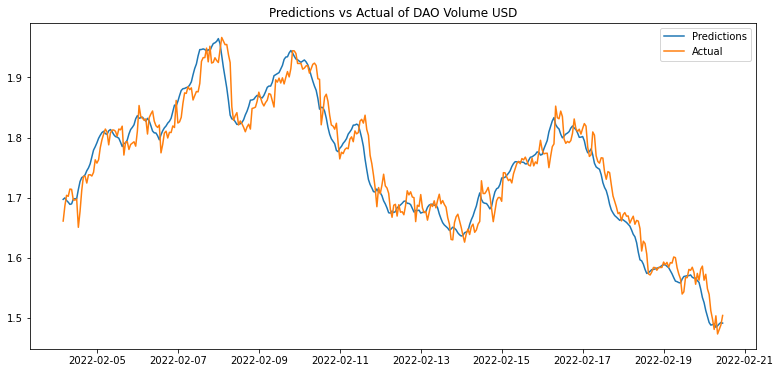

In [15]:
model_lstm = tf.keras.models.load_model("model_experiments/model_lstm/")
model_lstm.evaluate(test_windows, test_labels)

def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

model_lstm_preds = make_preds(model_lstm, test_windows)
model_lstm_preds[:10]

model_lstm_preds = np.array(model_lstm_preds)

fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(X_test[1:], model_lstm_preds, label = "Predictions")
ax.plot(X_test[1:], y_test[1:], label = "Actual")
ax.set_title("Predictions vs Actual of DAO Volume USD")
ax.legend()